## Data 604 Final Project

Using SimPy, write a process simulation that includes waiting time (discrete event simulation). You may use any topic of interest to you. Write the simulation and all of the following in Jupyter.

**1. State the problem and its significance.**

This project simulates a restaurant that offers 2 services to customers:

* **Self Service Buffet**    
    _The customer is provided with a plate and serves themselves to the buffet_.
    
    
* **Table Service**  
   _The customer is seated and their food is served to them by a waiter_.
   
There is one line for both services. The customer arrival rate is randomly generated using an exponential distribution with an arrival rate of ......


**2.  Provide a flow-chart model.**


**3.  Simulate the process for the appropriate number of iterations (justify).**


In [57]:
# Import the libraries required to perform the simulation.
import simpy
import numpy as np
import pandas as pd
import random

In [58]:
# Set seed and simulation time variables.
seed = 500

# Simulation time is representative of the restaurant's hours of business.
simulation_time = 12

# Instantiate a dataframe to contain the simulation results.
simulation_results = pd.DataFrame(columns = ['Customer', 'Service', 'Arrival Time',
                                             'Service Start Time', 'Service Stop Time'])


In [59]:
def generate_arrivals():
    """Generates customer arrivals at the restaurant.
    
    10 to 30 customers arrive at the restaurant every hour.
    """
    return np.random.exponential(60.0 / np.random.randint(10, 30))

In [60]:
def generate_buffet_service_time():
    """Generates service times for the buffet service."""
    return np.random.triangular(3, 4, 5)

In [61]:
def generate_table_service_time():
    """Generates service times for the table service."""
    return np.random.triangular(10, 15, 20)

In [62]:
def run_simulation(env, buffet, table_service):
    global current_hour
    customer = 0
    while True:
        service = np.random.choice(['Buffet', 'Table Service'], p = [0.85, 0.15])
        customer += 1
        yield env.timeout(generate_arrivals())
        env.process(generate_customer_report(env, customer, buffet, table_service, service))

In [63]:
def generate_customer_report(env, customer, buffet, table_service, Service):
    """ Generates the results of the simulation.
    
    Parameters:
        env (object): Simpy environment object - manages the simulation time.
        customer (int): Integer representing an individual customer.
        buffet (int): Total capacity for the buffet service. 
        table_service (int): Total capacity for the table service. 
        Service (string): Type of service (table service or buffet service).
    """
    global simulation_results

    with table_service.request() as request:
        arrival_time = env.now

        yield env.timeout(1/2)
        yield request

        service_start_time = env.now

        if Service == 'Table Service':
            yield env.timeout(generate_table_service_time())
        else:
            yield env.timeout(generate_buffet_service_time())

        service_stop_time = env.now 

        row = pd.DataFrame([['Customer_{}'.format(customer), Service, arrival_time, service_start_time,
                             service_stop_time]], columns = ['Customer', 'Service', 'Arrival Time',
                             'Service Start Time', 'Service Stop Time'])
       
        simulation_results = simulation_results.append(row, ignore_index = True, sort = False)

        # Calculate wait times.
        simulation_results['Service Time in Minutes'] = (simulation_results['Service Stop Time'] - simulation_results['Service Start Time'])
        simulation_results['Wait Time in Minutes'] = (simulation_results['Service Start Time'] - simulation_results['Arrival Time'])

In [64]:
def run_restaurant_model(simulation_runs, buffet_capacity, table_capacity):
    """ Runs the restaurant model.
    
    Parameters:
        env (int): An integer representing the amount of times the simulation should run. 
        buffet_capacity (int): Total capacity for the buffet service. 
        table_capacity (int): Total capacity for the table service. 

    Return:
        wait_times (Pandas Dataframe): A Pandas dataframe containing the model results.
    """
    global simulation_results
    
    # Initialize arrays to contain data.
    buffet_service = []
    table_service = []
    average_wait_time = []
    table_service_wait_time = []
    buffet_wait_time = []


    for count in range(simulation_runs):
        simulation_results = simulation_results[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        # Assign the buffet service as a resource.
        buffet = simpy.Resource(env, capacity = buffet_capacity)
        # Assign the table service as a resource.
        table = simpy.Resource(env, capacity = table_capacity)
        
        env.process(run_simulation(env, buffet, table))
        # Run for 12 hours.
        env.run(until = 12 * 60)
        
        
        buffet_service = simulation_results[simulation_results.Service.isin(['Buffet'])]
        table_service = simulation_results[simulation_results.Service.isin(['Table Service'])]

        # Calculate the average wait time for each service.
        average_wait = simulation_results['Wait Time in Minutes'].mean()
        average_wait_buffet = buffet_service['Wait Time in Minutes'].mean()
        average_wait_table = table_service['Wait Time in Minutes'].mean()
        
        # Append the results to the main wait time arrays.
        average_wait_time.append(average_wait)
        table_service_wait_time.append(average_wait_table)
        buffet_wait_time.append(average_wait_buffet)
        
    # Store the wait times in a dataframe.
    wait_times_dataframe = {"average_wait_time": average_wait_time,
                "table_service_wait_time": table_service_wait_time,
                "buffet_wait_time": buffet_wait_time}
    
    global wait_times
    # Store the wait time results in a Pandas' dataframe.
    wait_times = pd.DataFrame(wait_times_dataframe)

    # Return the results.
    return wait_times

In [65]:
# The restaurant is open 7 days a week so we run the model 30 times
# to reflect the number of working days in an average month.
np.random.seed(6758)
results = run_restaurant_model(30, 5, 1)

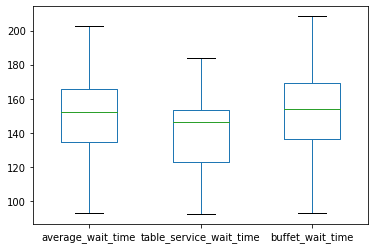

In [66]:
# Plot the wait time results.
box_plot = results.boxplot(grid = False, widths = 0.5)


4.  Justify the validity of the model and discuss how you verified it.

5.  State  your conclusions/ findings from the model. 

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  Post this to the discussion. 